In [0]:
import tensorflow as tf
print(tf.__version__)
import math

2.2.0


In [0]:
def rmse(y_true, y_pred):
	return backend.sqrt(backend.mean(backend.square(y_pred - y_true), axis=-1))

In [0]:
import numpy as np
import matplotlib.pyplot as plt
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

In [0]:
from google.colab import files
import io
import pandas as pd


In [0]:
uploaded = files.upload()

Saving hpq.us.txt to hpq.us.txt


In [0]:
  hpdf = pd.read_csv(io.BytesIO(uploaded['hpq.us.txt']))

In [0]:
hpdf.head()

,Date,Open,High,Low,Close,Volume,OpenInt
0,1970-01-02,0.30627,0.30627,0.30627,0.30627,2441124,0
1,1970-01-05,0.30627,0.31768,0.30627,0.31385,6219848,0
2,1970-01-06,0.31385,0.31385,0.30996,0.30996,4447522,0
3,1970-01-07,0.31385,0.31385,0.31385,0.31385,1872638,0
4,1970-01-08,0.31385,0.31768,0.31385,0.31385,4280330,0


In [0]:

hpdf['ret'] = hpdf.Close.pct_change(1).mul(100)

In [0]:
#uisng close price
series = hpdf['Close']
print(series)
type(series)
time = np.arange(0,12075,1)
print(time)


In [0]:
#uisng retunrs
series = hpdf['ret']
print(series)
type(series)
time = np.arange(0,12075,1)
print(time)


In [0]:
series = pd.Series.to_numpy(series)

In [0]:

series = series[1:]

In [0]:
series.shape

(12074,)

In [0]:
time = np.arange(0,12074,1)

In [0]:
time.shape

(12074,)

In [0]:
#Split dataset into test and trainig sets
split_time = 9000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]
#craeting hyperparamter values 
window_size = 64
batch_size = 128
shuffle_buffer_size = 1000


NameError: ignored

In [0]:
#create winidowed dataset
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    #split the data into feature and lables 
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [0]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [0]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
window_size = 64
batch_size = 256
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(x_train.shape)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mse"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])


<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>
(9000,)
Epoch 1/100
35/35 [==============================] - 1s 42ms/step - loss: 5.8614 - mse: 77.5596 - lr: 1.0000e-08
Epoch 2/100
35/35 [==============================] - 1s 43ms/step - loss: 5.2074 - mse: 65.9767 - lr: 1.1220e-08
Epoch 3/100
35/35 [==============================] - 2s 43ms/step - loss: 4.7109 - mse: 57.0276 - lr: 1.2589e-08
Epoch 4/100
35/35 [==============================] - 2s 44ms/step - loss: 4.4017 - mse: 51.0492 - lr: 1.4125e-08
Epoch 5/100
35/35 [==============================] - 2s 45ms/step - loss: 4.2215 - mse: 47.1768 - lr: 1.5849e-08
Epoch 6/100
35/35 [==============================] - 1s 42ms/step - loss: 4.1155 - mse: 44.6369 - lr: 1.7783e-08
Epoch 7/100
35/35 [==============================] - 1s 37ms/step - loss: 4.0452 - mse: 42.8451 - lr: 1.9953e-08
Epoch 8/100
35/35 [==============================] - 1s 37ms/step - loss: 3.9889 - mse: 41.4581 - lr: 2.238

(1e-08, 0.0001, 0.0, 60.0)

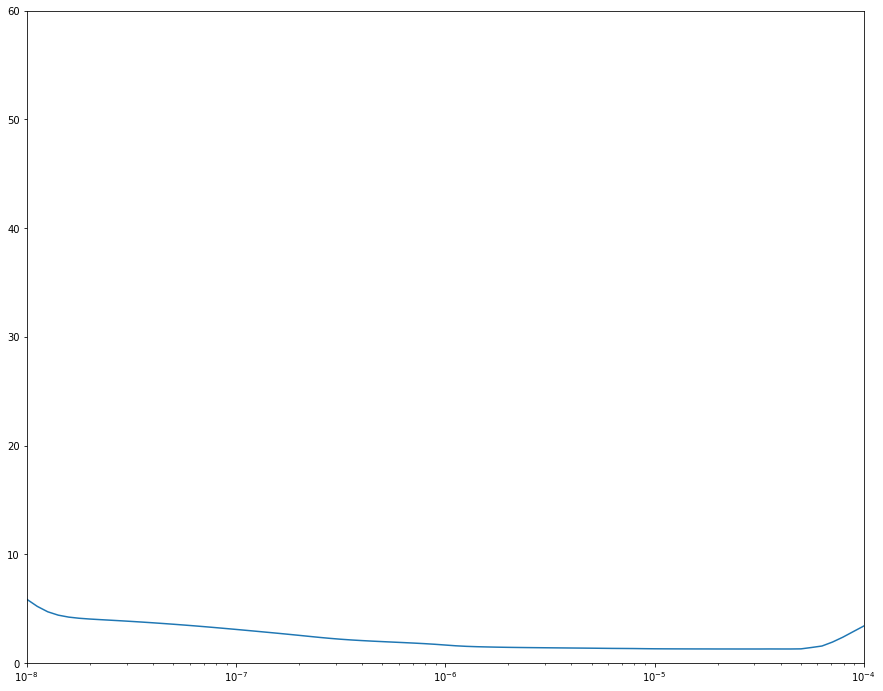

In [0]:
plt.figure(figsize=(15,12))
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 60])

In [0]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
train_set = windowed_dataset(x_train, window_size=60, batch_size=100, shuffle_buffer=shuffle_buffer_size)
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=60, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.Dense(32, activation="relu"),
  tf.keras.layers.Dense(16, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])


optimizer = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mse"])
history = model.fit(train_set,epochs=300)

Epoch 1/300
90/90 [==============================] - 1s 15ms/step - loss: 3.0638 - mse: 25.6839
Epoch 2/300
90/90 [==============================] - 1s 15ms/step - loss: 1.9476 - mse: 11.1885
Epoch 3/300
90/90 [==============================] - 1s 15ms/step - loss: 1.7457 - mse: 9.1650
Epoch 4/300
90/90 [==============================] - 1s 15ms/step - loss: 1.6639 - mse: 8.4424
Epoch 5/300
90/90 [==============================] - 1s 16ms/step - loss: 1.6146 - mse: 8.0425
Epoch 6/300
90/90 [==============================] - 1s 16ms/step - loss: 1.5822 - mse: 7.7838
Epoch 7/300
90/90 [==============================] - 1s 16ms/step - loss: 1.5562 - mse: 7.5928
Epoch 8/300
90/90 [==============================] - 1s 15ms/step - loss: 1.5373 - mse: 7.4518
Epoch 9/300
90/90 [==============================] - 1s 16ms/step - loss: 1.5205 - mse: 7.3250
Epoch 10/300
90/90 [==============================] - 1s 15ms/step - loss: 1.5069 - mse: 7.2226
Epoch 11/300
90/90 [===========================

In [0]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

In [0]:
tf.keras.metrics.mse(x_valid, rnn_forecast).numpy()

4.300997

In [0]:
RMSE = math.sqrt(tf.keras.metrics.mse(x_valid, rnn_forecast).numpy())
print('RMSE is equal to %.5f' %RMSE)

RMSE is equal to 2.07388


In [0]:

time_valid.shape

(3074,)

Text(0.5, 1.0, 'HP stock Predicton vs Actual')

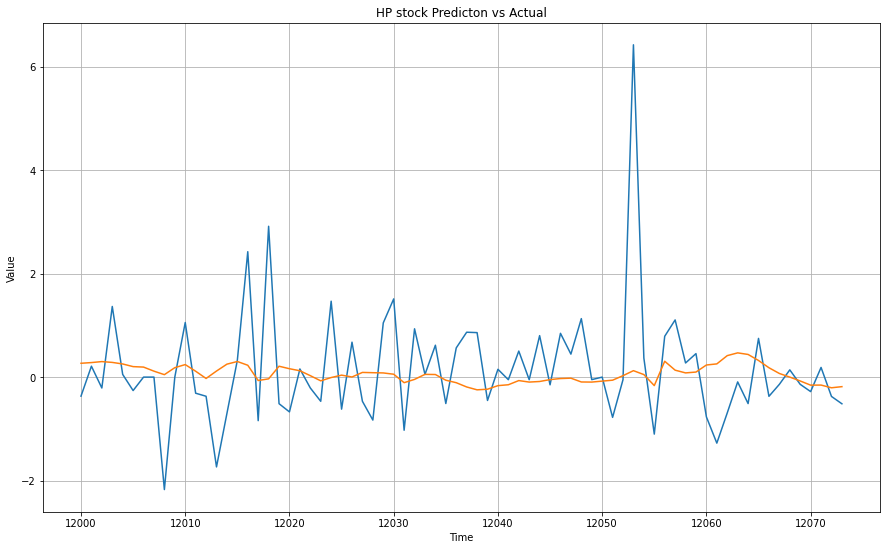

In [0]:
plt.figure(figsize=(15,9))
plot_series(time_valid[3000:3075], x_valid[3000:3075])
plot_series(time_valid[3000:3075], rnn_forecast[3000:3075])
plt.title("HP stock Predicton vs Actual")

Text(0.5, 1.0, 'HP stock predciton vs Actual')

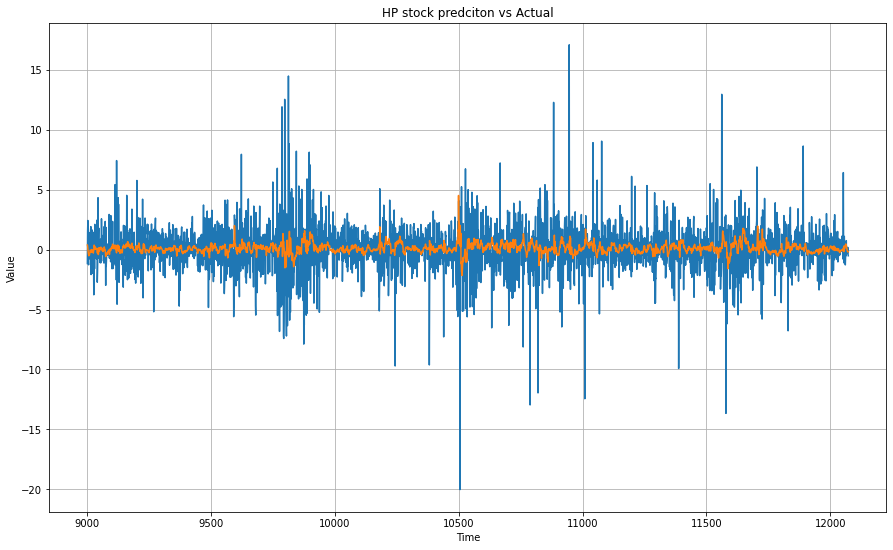

In [0]:
plt.figure(figsize=(15,9))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)
plt.title("HP stock predciton vs Actual")

In [0]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

0.25636676

In [0]:
print(rnn_forecast)

[10.3865385 10.457462  10.49107   ... 21.778002  21.76139   21.73102  ]


In [0]:
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))

<Figure size 864x648 with 0 Axes>

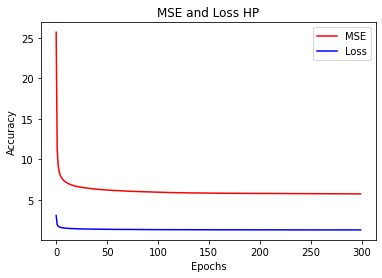

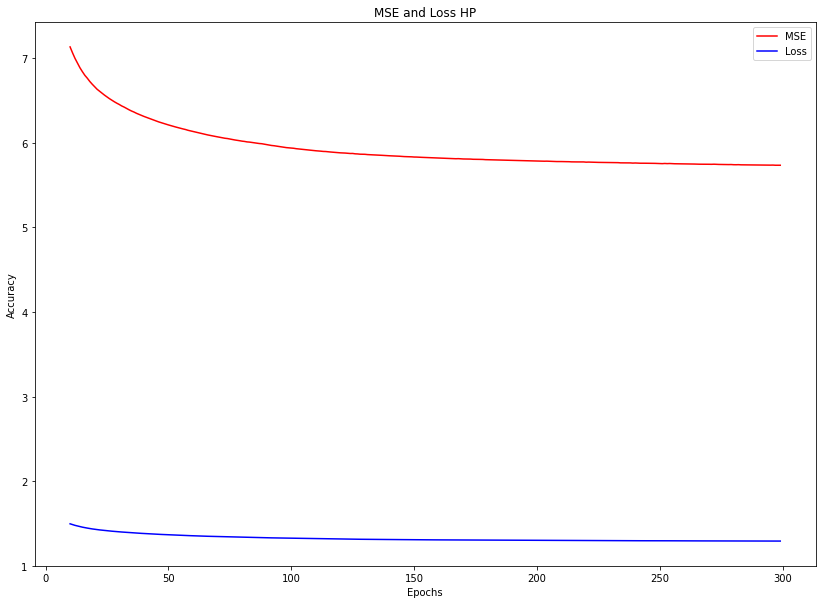

<Figure size 864x648 with 0 Axes>

In [0]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
mse=history.history['mse']
loss=history.history['loss']

epochs=range(len(loss)) # Get number of epochs

#------------------------------------------------
# Plot MAE and Loss
#------------------------------------------------
plt.plot(epochs, mse, 'r')
plt.plot(epochs, loss, 'b')
plt.title('MSE and Loss HP')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MSE", "Loss"])

epochs_zoom = epochs[10:]
mse_zoom = mse[10:]
loss_zoom = loss[10:]
plt.figure(figsize=(14,10))

#------------------------------------------------
# Plot Zoomed MAE and Loss
#------------------------------------------------
plt.plot(epochs_zoom, mse_zoom, 'r')
plt.plot(epochs_zoom, loss_zoom, 'b')
plt.title('MSE and Loss HP')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MSE", "Loss"])
plt.figure(figsize=(12,9))


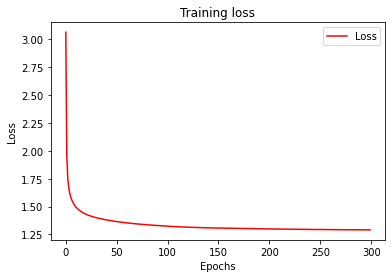

<Figure size 432x288 with 0 Axes>

In [0]:
plt.plot(epochs, loss, 'r')
plt.title('Training loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss"])
plt.figure()
zoomed_loss = loss[100:]
zoomed_epochs = range(100,300)

<Figure size 432x288 with 0 Axes>

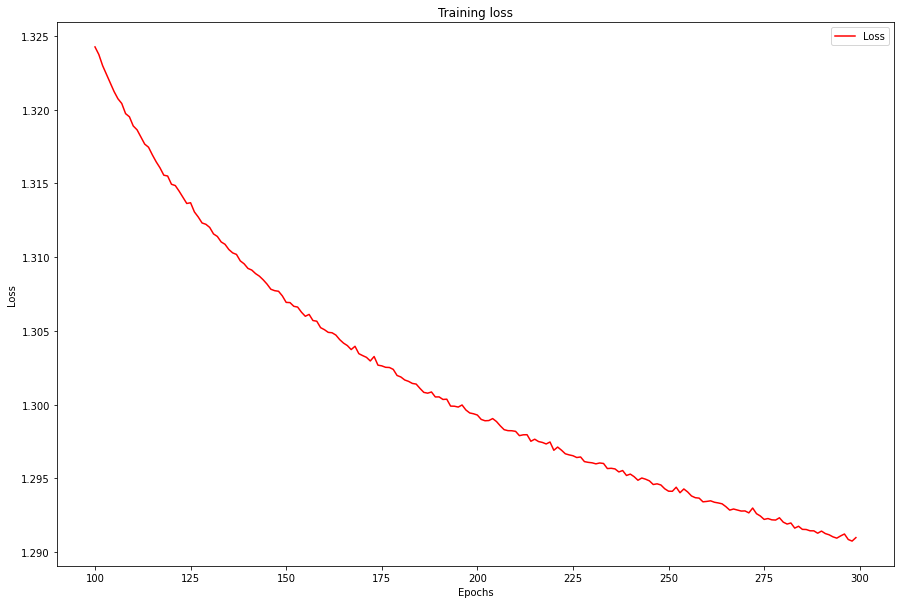

<Figure size 432x288 with 0 Axes>

In [0]:
plt.figure(figsize=(15,10))
plt.plot(zoomed_epochs, zoomed_loss, 'r')
plt.title('Training loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss"])
plt.figure()